In [1]:
import FCA, pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

In [2]:
### from network_sampling_ex
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            #H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            #W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H
    
def display_dictionary(W, save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [3]:
# FCA_iter: total iteration for the FCA model, used for label
# baseline_iter: the iteration for baseline model, usually less than FCA_iter
# iter_include: number of iteration to include in the dataframe
# X: a list of graph structure (for each graph, length = k^2 if num_nodes=k)
# num_edges, num_nodes, min_degree, max_degree, diameter, quartile_1, quartile_2, quartile_3, states, y, baseline_width
def FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, iter_include, file_name, X):
    # generate the toy dataset
    file = open(file_name, 'w+', newline='')

    header = ["num_edges", "num_nodes", "min_degree", "max_degree", "diameter", "quartile_1",
              "quartile_2", "quartile_3", "y", "baseline_width"]
    for i in range(baseline_iter):
        for j in range(num_nodes):
            header.append("s" + str(i + 1) + "_" + str(j + 1))

    with file:
        write = csv.writer(file)

        write.writerow(header)
        for i in range(X.shape[1]): #X.shape = (400, 3000)
            G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(20, -1)))
            G=nx.Graph(G)
            
            
            col = np.random.randint(0,kappa,size=num_nodes)

            num_edges = G.number_of_edges()
            min_degree = min(list(G.degree), key=lambda x: x[1])[1]
            max_degree = max(list(G.degree), key=lambda x: x[1])[1]
            diameter = nx.diameter(G)
            quartile_1 = s.quantiles(col, n=4)[0]
            quartile_2 = s.quantiles(col, n=4)[1]
            quartile_3 = s.quantiles(col, n=4)[2]

            sample = [num_edges, num_nodes, min_degree, max_degree, diameter,
                      quartile_1, quartile_2, quartile_3]
            states, label = FCA.FCA(G, col, kappa, FCA_iter)

            width = FCA.width_compute(states[FCA_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True
            sample.append(y)

            baseline_width = FCA.width_compute(states[baseline_iter - 1], kappa)
            baseline = False
            if (baseline_width < floor(kappa / 2)):  # half circle concentration
                baseline = True
            sample.append(baseline)

            for j in range(iter_include):
                sample = sample + list(states[j])

            write.writerow(sample)
    #return graph_list

## Data Generation

In [4]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/test1/'
k=20

path = "Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

OSError: Data/Networks_all_NDL/Caltech36.txt not found.

In [199]:
X, embs = G.get_patches(k=k, sample_size=10000, skip_folded_hom=True)
file = open('toy.pkl', 'wb')
pickle.dump(X, file)
file.close()
X.shape
#X[:,0].reshape(20, -1) #adjacency matrix of the first sample
#int(np.sqrt(X.shape[0]))
#G=nx.from_pandas_adjacency(pd.DataFrame(X[:,0].reshape(20, -1)))
#G=nx.Graph(G)

num of subgraphs induced on k-paths: 10000


(400, 10000)

In [200]:
num_nodes = 20
kappa = 10
FCA_iter = 200
baseline_iter = 50
iter_include = 5
file_name = "toy.csv"
FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, iter_include, file_name, X)

## toy_Caltech36_20walk

In [243]:
fileo = open('toy_Caltech36_20walk.pkl', 'rb')
X = pickle.load(fileo)
fileo.close()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

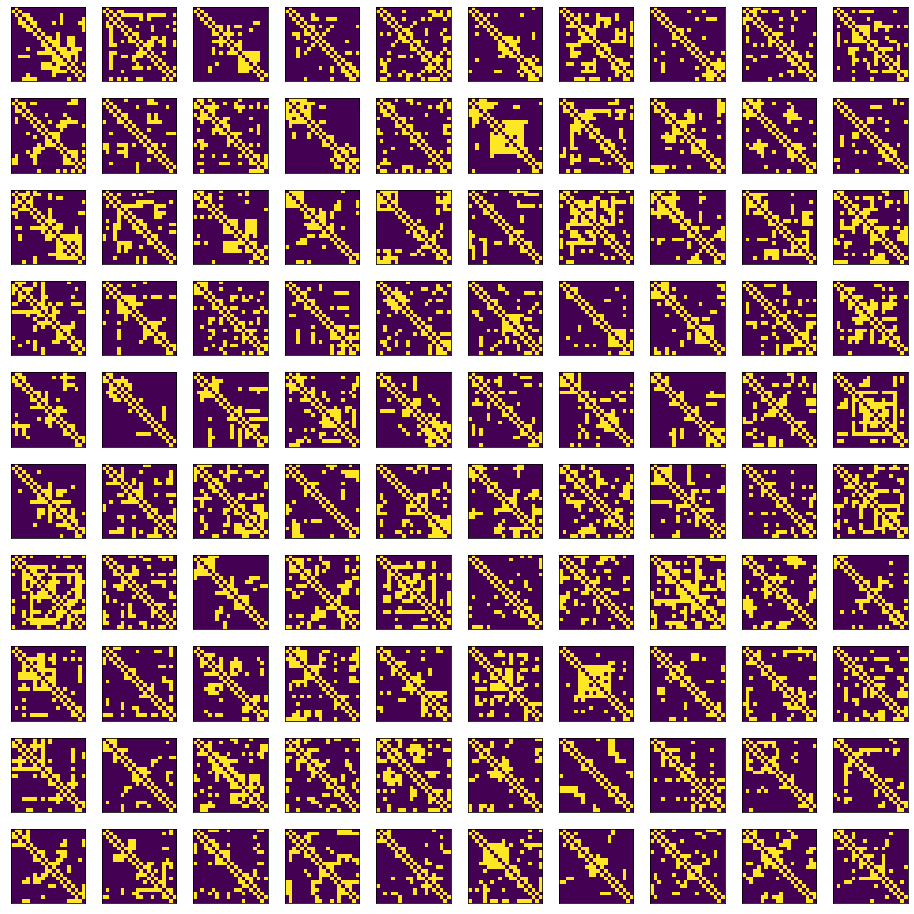

In [244]:
display_dictionary(X[:,:100], figsize=[15,15])

In [245]:
df = pd.read_csv("toy_Caltech36_20walk.csv")
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s5_11,s5_12,s5_13,s5_14,s5_15,s5_16,s5_17,s5_18,s5_19,s5_20
0,56,20,1,10,5,2.00,4.0,7.75,True,False,...,4,9,4,7,6,4,1,9,7,4
1,56,20,1,14,4,1.00,3.5,6.00,True,True,...,5,7,7,8,9,5,6,7,6,4
2,41,20,1,10,7,3.00,3.5,7.00,True,False,...,7,2,7,0,0,3,7,3,7,7
3,38,20,1,7,6,2.25,5.0,7.00,True,False,...,5,7,9,6,0,8,8,0,7,9
4,55,20,1,8,4,3.25,5.0,7.00,True,True,...,5,6,2,7,7,5,8,0,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,30,20,2,5,6,1.25,4.5,6.75,False,False,...,9,9,4,9,5,5,2,8,0,6
9996,50,20,1,10,5,1.25,4.0,6.00,True,True,...,4,7,4,0,9,7,6,7,9,8
9997,55,20,2,10,4,3.00,4.0,6.75,True,True,...,6,9,6,9,6,6,5,6,7,8
9998,46,20,2,9,4,2.00,3.5,5.75,True,True,...,7,7,7,7,5,6,0,1,6,4


In [246]:
df.y.value_counts()

True     9227
False     773
Name: y, dtype: int64

In [247]:
df.baseline_width.value_counts()

False    5290
True     4710
Name: baseline_width, dtype: int64

In [248]:
df['y'] = df['y'].astype(int)
df['baseline_width'] = df['baseline_width'].astype(int)
y = df['y']
df.drop('y', axis=1, inplace=True)
df.drop('num_nodes', axis=1, inplace=True)

In [249]:
df.shape

(10000, 108)

In [250]:
df_false = pd.concat([df[y == 0], pd.DataFrame(X.T)[y == 0]], 
          axis=1, join='inner')
df_true = pd.concat([df[y == 1], pd.DataFrame(X.T)[y == 1]], 
          axis=1, join='inner')
X_false = df_false.to_numpy().T
X_true = df_true.to_numpy().T

In [251]:
X_false.shape

(508, 773)

In [252]:
X_true.shape

(508, 9227)

In [253]:
W_false, H = ALS(X=X_false, 
           n_components=16, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  3%|▎         | 29/1000 [00:00<00:03, 283.17it/s]

iteration 0, reconstruction error 4088433.171882
iteration 10, reconstruction error 846508.994382
iteration 20, reconstruction error 943087.618993
iteration 30, reconstruction error 806277.894256
iteration 40, reconstruction error 659688.390004
iteration 50, reconstruction error 565247.604095


 11%|█         | 110/1000 [00:00<00:03, 251.76it/s]

iteration 60, reconstruction error 512101.058849
iteration 70, reconstruction error 481048.713355
iteration 80, reconstruction error 461502.965689
iteration 90, reconstruction error 449566.229202
iteration 100, reconstruction error 442211.573469
iteration 110, reconstruction error 437501.187322


 17%|█▋        | 168/1000 [00:00<00:03, 272.77it/s]

iteration 120, reconstruction error 434302.120819
iteration 130, reconstruction error 431987.271391
iteration 140, reconstruction error 430201.412471
iteration 150, reconstruction error 428760.163796
iteration 160, reconstruction error 427560.925161
iteration 170, reconstruction error 426523.391007
iteration 180, reconstruction error 425610.883925


 22%|██▏       | 223/1000 [00:00<00:02, 268.32it/s]

iteration 190, reconstruction error 424793.605538
iteration 200, reconstruction error 424053.345009
iteration 210, reconstruction error 423378.583542
iteration 220, reconstruction error 422763.467406
iteration 230, reconstruction error 422195.586899
iteration 240, reconstruction error 421667.740908


 28%|██▊       | 284/1000 [00:01<00:02, 270.94it/s]

iteration 250, reconstruction error 421176.023691
iteration 260, reconstruction error 420716.714385
iteration 270, reconstruction error 420287.312865
iteration 280, reconstruction error 419886.114344
iteration 290, reconstruction error 419508.700564
iteration 300, reconstruction error 419153.748343


 34%|███▍      | 344/1000 [00:01<00:02, 266.83it/s]

iteration 310, reconstruction error 418826.048248
iteration 320, reconstruction error 418519.436013
iteration 330, reconstruction error 418230.540015
iteration 340, reconstruction error 417956.734344
iteration 350, reconstruction error 417697.046487
iteration 360, reconstruction error 417450.988349


 40%|███▉      | 399/1000 [00:01<00:02, 254.99it/s]

iteration 370, reconstruction error 417215.923770
iteration 380, reconstruction error 416991.192946
iteration 390, reconstruction error 416775.640366
iteration 400, reconstruction error 416567.919836
iteration 410, reconstruction error 416367.450718
iteration 420, reconstruction error 416174.532999


 50%|████▉     | 499/1000 [00:01<00:01, 309.36it/s]

iteration 430, reconstruction error 415988.544900
iteration 440, reconstruction error 415809.319986
iteration 450, reconstruction error 415635.544552
iteration 460, reconstruction error 415467.895060
iteration 470, reconstruction error 415308.059186
iteration 480, reconstruction error 415152.800427
iteration 490, reconstruction error 415001.698766
iteration 500, reconstruction error 414854.855704


 56%|█████▌    | 562/1000 [00:02<00:01, 288.65it/s]

iteration 510, reconstruction error 414712.565602
iteration 520, reconstruction error 414574.758907
iteration 530, reconstruction error 414440.822461
iteration 540, reconstruction error 414310.360434
iteration 550, reconstruction error 414184.070205
iteration 560, reconstruction error 414061.482310


 62%|██████▏   | 622/1000 [00:02<00:01, 281.41it/s]

iteration 570, reconstruction error 413942.140567
iteration 580, reconstruction error 413825.852622
iteration 590, reconstruction error 413712.968714
iteration 600, reconstruction error 413603.704988
iteration 610, reconstruction error 413498.019502
iteration 620, reconstruction error 413395.697578


 68%|██████▊   | 680/1000 [00:02<00:01, 281.77it/s]

iteration 630, reconstruction error 413297.046002
iteration 640, reconstruction error 413201.513321
iteration 650, reconstruction error 413108.976928
iteration 660, reconstruction error 413018.853835
iteration 670, reconstruction error 412930.920194
iteration 680, reconstruction error 412845.091388


 74%|███████▍  | 741/1000 [00:02<00:00, 288.03it/s]

iteration 690, reconstruction error 412761.170432
iteration 700, reconstruction error 412679.009901
iteration 710, reconstruction error 412598.476318
iteration 720, reconstruction error 412519.249071
iteration 730, reconstruction error 412441.232996
iteration 740, reconstruction error 412364.318537


 80%|███████▉  | 798/1000 [00:02<00:00, 266.04it/s]

iteration 750, reconstruction error 412288.367519
iteration 760, reconstruction error 412213.402023
iteration 770, reconstruction error 412139.211772
iteration 780, reconstruction error 412065.829839
iteration 790, reconstruction error 411993.126414


 85%|████████▌ | 851/1000 [00:03<00:00, 254.59it/s]

iteration 800, reconstruction error 411920.969095
iteration 810, reconstruction error 411849.282177
iteration 820, reconstruction error 411777.965352
iteration 830, reconstruction error 411707.005374
iteration 840, reconstruction error 411636.658681
iteration 850, reconstruction error 411567.857823


 92%|█████████▏| 916/1000 [00:03<00:00, 287.61it/s]

iteration 860, reconstruction error 411500.307036
iteration 870, reconstruction error 411433.563926
iteration 880, reconstruction error 411367.438823
iteration 890, reconstruction error 411301.751926
iteration 900, reconstruction error 411236.641711
iteration 910, reconstruction error 411172.346840
iteration 920, reconstruction error 411108.888368


 98%|█████████▊| 977/1000 [00:03<00:00, 293.87it/s]

iteration 930, reconstruction error 411045.870606
iteration 940, reconstruction error 410983.365206
iteration 950, reconstruction error 410921.350906
iteration 960, reconstruction error 410859.588677
iteration 970, reconstruction error 410797.982419
iteration 980, reconstruction error 410736.493697


100%|██████████| 1000/1000 [00:03<00:00, 275.30it/s]

iteration 990, reconstruction error 410675.068514


In [254]:
W_true, H = ALS(X=X_true, 
           n_components=16, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  0%|          | 3/1000 [00:00<00:38, 25.94it/s]

iteration 0, reconstruction error 55668933.769751


  2%|▏         | 17/1000 [00:00<00:33, 29.78it/s]

iteration 10, reconstruction error 10358423.085000


  2%|▏         | 24/1000 [00:00<00:33, 29.06it/s]

iteration 20, reconstruction error 11857186.166121


  4%|▎         | 35/1000 [00:01<00:32, 29.69it/s]

iteration 30, reconstruction error 10182993.066652


  5%|▍         | 47/1000 [00:01<00:32, 29.49it/s]

iteration 40, reconstruction error 8342144.788996


  6%|▌         | 57/1000 [00:01<00:31, 29.73it/s]

iteration 50, reconstruction error 7393779.143896


  6%|▋         | 65/1000 [00:02<00:31, 30.09it/s]

iteration 60, reconstruction error 6620227.370636


  8%|▊         | 77/1000 [00:02<00:30, 30.38it/s]

iteration 70, reconstruction error 6076870.168472


  8%|▊         | 85/1000 [00:02<00:30, 30.32it/s]

iteration 80, reconstruction error 5730556.163004


 10%|▉         | 97/1000 [00:03<00:29, 30.28it/s]

iteration 90, reconstruction error 5500056.405691


 10%|█         | 105/1000 [00:03<00:29, 29.85it/s]

iteration 100, reconstruction error 5356451.548756


 12%|█▏        | 115/1000 [00:03<00:30, 29.33it/s]

iteration 110, reconstruction error 5266368.231721


 12%|█▎        | 125/1000 [00:04<00:30, 28.42it/s]

iteration 120, reconstruction error 5207554.035535


 14%|█▎        | 135/1000 [00:04<00:29, 29.43it/s]

iteration 130, reconstruction error 5167201.464704


 14%|█▍        | 145/1000 [00:04<00:29, 29.32it/s]

iteration 140, reconstruction error 5137798.426176


 16%|█▌        | 156/1000 [00:05<00:28, 29.30it/s]

iteration 150, reconstruction error 5115052.219459


 17%|█▋        | 167/1000 [00:05<00:28, 29.72it/s]

iteration 160, reconstruction error 5096553.185997


 18%|█▊        | 175/1000 [00:05<00:27, 29.93it/s]

iteration 170, reconstruction error 5080829.414093


 19%|█▊        | 187/1000 [00:06<00:27, 30.08it/s]

iteration 180, reconstruction error 5067037.573821


 20%|█▉        | 195/1000 [00:06<00:26, 29.90it/s]

iteration 190, reconstruction error 5054664.577455


 21%|██        | 207/1000 [00:07<00:26, 29.73it/s]

iteration 200, reconstruction error 5043354.878913


 22%|██▏       | 215/1000 [00:07<00:26, 29.82it/s]

iteration 210, reconstruction error 5032868.318840


 22%|██▎       | 225/1000 [00:07<00:25, 29.83it/s]

iteration 220, reconstruction error 5023091.997394


 24%|██▎       | 237/1000 [00:08<00:25, 30.23it/s]

iteration 230, reconstruction error 5013903.217081


 24%|██▍       | 245/1000 [00:08<00:25, 29.83it/s]

iteration 240, reconstruction error 5005237.726572


 26%|██▌       | 257/1000 [00:08<00:24, 30.23it/s]

iteration 250, reconstruction error 4997031.478708


 26%|██▋       | 265/1000 [00:08<00:24, 29.85it/s]

iteration 260, reconstruction error 4989289.099098


 28%|██▊       | 277/1000 [00:09<00:24, 29.98it/s]

iteration 270, reconstruction error 4982010.387539


 28%|██▊       | 285/1000 [00:09<00:24, 29.58it/s]

iteration 280, reconstruction error 4975140.593719


 30%|██▉       | 296/1000 [00:10<00:23, 29.62it/s]

iteration 290, reconstruction error 4968529.085294


 31%|███       | 307/1000 [00:10<00:23, 29.33it/s]

iteration 300, reconstruction error 4962159.463311


 32%|███▏      | 315/1000 [00:10<00:22, 30.00it/s]

iteration 310, reconstruction error 4956026.892730


 33%|███▎      | 327/1000 [00:11<00:21, 30.81it/s]

iteration 320, reconstruction error 4950109.083534


 34%|███▎      | 335/1000 [00:11<00:21, 30.39it/s]

iteration 330, reconstruction error 4944391.510579


 35%|███▍      | 347/1000 [00:11<00:21, 30.71it/s]

iteration 340, reconstruction error 4938896.035458


 36%|███▌      | 355/1000 [00:12<00:21, 30.54it/s]

iteration 350, reconstruction error 4933611.119795


 37%|███▋      | 367/1000 [00:12<00:20, 30.61it/s]

iteration 360, reconstruction error 4928565.339656


 37%|███▋      | 374/1000 [00:12<00:21, 29.36it/s]

iteration 370, reconstruction error 4923755.492358


 38%|███▊      | 385/1000 [00:13<00:22, 27.72it/s]

iteration 380, reconstruction error 4919162.081626


 40%|███▉      | 395/1000 [00:13<00:21, 27.86it/s]

iteration 390, reconstruction error 4914768.407424


 40%|████      | 404/1000 [00:13<00:22, 26.32it/s]

iteration 400, reconstruction error 4910555.539636


 41%|████▏     | 414/1000 [00:14<00:23, 25.45it/s]

iteration 410, reconstruction error 4906520.031144


 42%|████▎     | 425/1000 [00:14<00:20, 28.46it/s]

iteration 420, reconstruction error 4902645.910203


 44%|████▎     | 436/1000 [00:14<00:19, 29.25it/s]

iteration 430, reconstruction error 4898914.415036


 45%|████▍     | 446/1000 [00:15<00:18, 29.20it/s]

iteration 440, reconstruction error 4895313.457082


 46%|████▌     | 456/1000 [00:15<00:19, 28.60it/s]

iteration 450, reconstruction error 4891828.357652


 47%|████▋     | 467/1000 [00:15<00:18, 29.40it/s]

iteration 460, reconstruction error 4888531.185011


 48%|████▊     | 476/1000 [00:16<00:18, 28.32it/s]

iteration 470, reconstruction error 4885353.880846


 49%|████▊     | 486/1000 [00:16<00:17, 28.83it/s]

iteration 480, reconstruction error 4882277.908136


 50%|████▉     | 497/1000 [00:17<00:17, 29.32it/s]

iteration 490, reconstruction error 4879306.053354


 50%|█████     | 503/1000 [00:17<00:19, 25.41it/s]

iteration 500, reconstruction error 4876446.647021


 52%|█████▏    | 516/1000 [00:17<00:17, 27.34it/s]

iteration 510, reconstruction error 4873687.617091


 53%|█████▎    | 527/1000 [00:18<00:16, 28.61it/s]

iteration 520, reconstruction error 4871014.952642


 54%|█████▎    | 536/1000 [00:18<00:18, 25.45it/s]

iteration 530, reconstruction error 4868424.731505


 55%|█████▍    | 546/1000 [00:18<00:16, 28.30it/s]

iteration 540, reconstruction error 4865907.160575


 56%|█████▌    | 556/1000 [00:19<00:15, 28.74it/s]

iteration 550, reconstruction error 4863455.349054


 56%|█████▋    | 563/1000 [00:19<00:16, 26.42it/s]

iteration 560, reconstruction error 4861064.107202


 57%|█████▊    | 575/1000 [00:19<00:16, 25.00it/s]

iteration 570, reconstruction error 4858727.586710


 58%|█████▊    | 584/1000 [00:20<00:16, 24.88it/s]

iteration 580, reconstruction error 4856444.875122


 60%|█████▉    | 595/1000 [00:20<00:14, 28.48it/s]

iteration 590, reconstruction error 4854217.777209


 61%|██████    | 606/1000 [00:21<00:13, 29.23it/s]

iteration 600, reconstruction error 4852038.681691


 62%|██████▏   | 616/1000 [00:21<00:13, 29.52it/s]

iteration 610, reconstruction error 4849913.583710


 63%|██████▎   | 627/1000 [00:21<00:12, 29.82it/s]

iteration 620, reconstruction error 4847843.134163


 64%|██████▎   | 637/1000 [00:22<00:12, 29.63it/s]

iteration 630, reconstruction error 4845821.884730


 64%|██████▍   | 645/1000 [00:22<00:11, 29.74it/s]

iteration 640, reconstruction error 4843858.858569


 66%|██████▌   | 657/1000 [00:22<00:11, 30.23it/s]

iteration 650, reconstruction error 4841942.697564


 66%|██████▋   | 665/1000 [00:23<00:11, 30.18it/s]

iteration 660, reconstruction error 4840080.585606


 68%|██████▊   | 677/1000 [00:23<00:10, 30.46it/s]

iteration 670, reconstruction error 4838277.407302


 68%|██████▊   | 685/1000 [00:23<00:10, 30.42it/s]

iteration 680, reconstruction error 4836523.547568


 70%|██████▉   | 697/1000 [00:24<00:09, 30.64it/s]

iteration 690, reconstruction error 4834816.133876


 70%|███████   | 705/1000 [00:24<00:09, 30.52it/s]

iteration 700, reconstruction error 4833151.160454


 72%|███████▏  | 716/1000 [00:24<00:09, 28.69it/s]

iteration 710, reconstruction error 4831526.551395


 73%|███████▎  | 727/1000 [00:25<00:09, 29.83it/s]

iteration 720, reconstruction error 4829939.415823


 74%|███████▎  | 735/1000 [00:25<00:08, 29.98it/s]

iteration 730, reconstruction error 4828388.198913


 75%|███████▍  | 747/1000 [00:25<00:08, 30.05it/s]

iteration 740, reconstruction error 4826874.969459


 76%|███████▌  | 755/1000 [00:26<00:08, 30.28it/s]

iteration 750, reconstruction error 4825399.988475


 77%|███████▋  | 767/1000 [00:26<00:07, 30.76it/s]

iteration 760, reconstruction error 4823966.546769


 78%|███████▊  | 775/1000 [00:26<00:07, 30.45it/s]

iteration 770, reconstruction error 4822580.499146


 79%|███████▊  | 787/1000 [00:27<00:06, 30.61it/s]

iteration 780, reconstruction error 4821238.895789


 79%|███████▉  | 794/1000 [00:27<00:06, 29.63it/s]

iteration 790, reconstruction error 4819943.540898


 80%|████████  | 805/1000 [00:27<00:06, 29.98it/s]

iteration 800, reconstruction error 4818695.990462


 82%|████████▏ | 817/1000 [00:28<00:06, 30.48it/s]

iteration 810, reconstruction error 4817485.938577


 82%|████████▎ | 825/1000 [00:28<00:05, 30.04it/s]

iteration 820, reconstruction error 4816303.729305


 84%|████████▎ | 837/1000 [00:28<00:05, 30.56it/s]

iteration 830, reconstruction error 4815146.760406


 84%|████████▍ | 845/1000 [00:29<00:05, 30.40it/s]

iteration 840, reconstruction error 4814008.458450


 86%|████████▌ | 857/1000 [00:29<00:04, 30.72it/s]

iteration 850, reconstruction error 4812886.492464


 86%|████████▋ | 865/1000 [00:29<00:04, 30.45it/s]

iteration 860, reconstruction error 4811778.401586


 88%|████████▊ | 877/1000 [00:30<00:04, 30.67it/s]

iteration 870, reconstruction error 4810691.458183


 88%|████████▊ | 885/1000 [00:30<00:03, 30.27it/s]

iteration 880, reconstruction error 4809647.805291


 90%|████████▉ | 897/1000 [00:30<00:03, 30.53it/s]

iteration 890, reconstruction error 4808618.391277


 90%|█████████ | 905/1000 [00:31<00:03, 30.25it/s]

iteration 900, reconstruction error 4807599.155517


 92%|█████████▏| 917/1000 [00:31<00:02, 29.98it/s]

iteration 910, reconstruction error 4806588.422263


 92%|█████████▎| 925/1000 [00:31<00:02, 29.98it/s]

iteration 920, reconstruction error 4805585.116588


 94%|█████████▎| 937/1000 [00:32<00:02, 30.44it/s]

iteration 930, reconstruction error 4804588.278411


 94%|█████████▍| 945/1000 [00:32<00:01, 30.19it/s]

iteration 940, reconstruction error 4803597.208270


 96%|█████████▌| 957/1000 [00:32<00:01, 30.46it/s]

iteration 950, reconstruction error 4802612.664499


 96%|█████████▋| 965/1000 [00:33<00:01, 30.01it/s]

iteration 960, reconstruction error 4801633.193246


 98%|█████████▊| 977/1000 [00:33<00:00, 29.99it/s]

iteration 970, reconstruction error 4800658.214824


 98%|█████████▊| 984/1000 [00:33<00:00, 28.78it/s]

iteration 980, reconstruction error 4799687.723466


100%|█████████▉| 995/1000 [00:34<00:00, 29.62it/s]

iteration 990, reconstruction error 4798721.711946


100%|██████████| 1000/1000 [00:34<00:00, 29.17it/s]


In [257]:
W_false[108:508,:].shape

(400, 16)

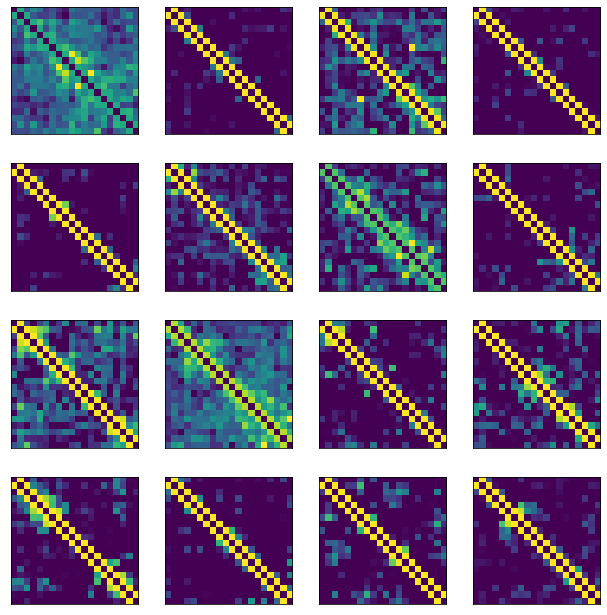

In [258]:
display_dictionary(W_false[108:508,:], figsize=[10,10])

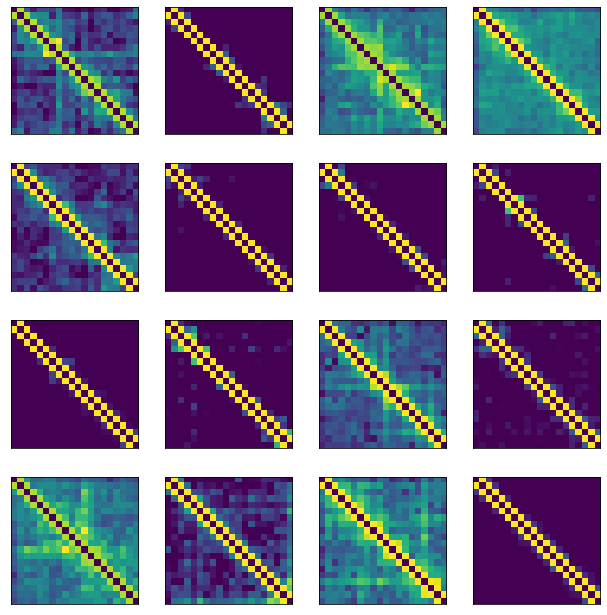

In [259]:
display_dictionary(W_true[108:508,:], figsize=[10,10])

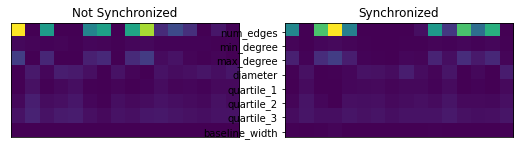

In [269]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

axs[1].set_yticks(np.arange(8) + 0.1, minor=False)

axs[0].imshow(W_false[0:8,:], cmap='viridis')
axs[0].set_title("Not Synchronized")
axs[1].imshow(W_true[0:8,:], cmap='viridis')
axs[1].set_title("Synchronized")

row_labels = df.columns[0:8]
axs[1].set_yticklabels(row_labels, minor=False)

plt.show()

In [277]:
pd.DataFrame(W_false[108:508,:]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,4.000000e+02,400.000000,400.000000
mean,0.001074,0.000290,0.000498,0.000320,0.000309,0.000508,0.000539,0.000283,0.000653,0.000911,0.000346,0.000366,0.000364,2.887480e-04,0.000303,0.000354
std,0.000586,0.000743,0.000576,0.000829,0.000783,0.000758,0.000589,0.000644,0.000668,0.000608,0.000712,0.000592,0.000665,6.832676e-04,0.000605,0.000769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000040,0.000465,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,0.001031,0.000000,0.000313,0.000000,0.000000,0.000177,0.000290,0.000000,0.000525,0.000814,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,0.001516,0.000002,0.000747,0.000035,0.000000,0.000641,0.000976,0.000125,0.000879,0.001240,0.000281,0.000554,0.000388,3.966793e-07,0.000316,0.000233
max,0.002938,0.002521,0.001914,0.002830,0.002627,0.002556,0.002155,0.002174,0.002175,0.002399,0.002334,0.001879,0.002070,2.275012e-03,0.001981,0.002546


In [278]:
pd.DataFrame(W_true[108:508,:]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000472,0.000183,0.000816,0.001331,0.000472,0.000211,0.000191,0.000131,0.000308,0.000186,0.000654,0.000317,0.000877,0.000388,0.000682,0.000302
std,0.000392,0.000498,0.000371,0.000552,0.000505,0.000606,0.000541,0.000357,0.000893,0.000466,0.000464,0.000769,0.000388,0.000472,0.000350,0.000847
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000188,0.000000,0.000596,0.001114,0.000158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000377,0.000000,0.000637,0.000036,0.000462,0.000000
50%,0.000378,0.000000,0.000757,0.001267,0.000319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000516,0.000000,0.000853,0.000228,0.000633,0.000000
75%,0.000635,0.000000,0.001039,0.001448,0.000542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000792,0.000152,0.001074,0.000481,0.000869,0.000000
max,0.001555,0.001692,0.001686,0.002612,0.001817,0.002069,0.001841,0.001203,0.003051,0.001539,0.001789,0.002638,0.001820,0.001631,0.001412,0.002895


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>],
       [<AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>],
       [<AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>,
        <AxesSubplot:title={'center':'15'}>]], dtype=object)

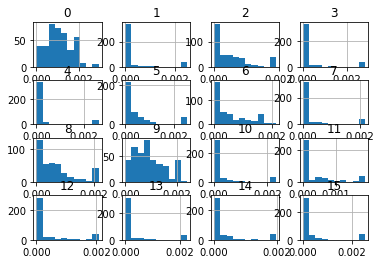

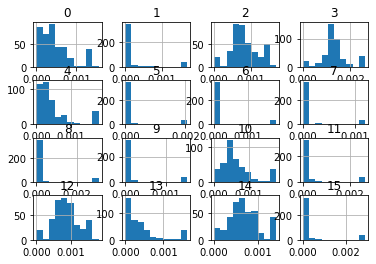

In [279]:
pd.DataFrame(W_false[108:508,:]).hist()
pd.DataFrame(W_true[108:508,:]).hist()

## SDL

In [226]:
#from SDL_src.LMF import LMF, update_code_within_radius
from SDL_src.SNMF import SNMF
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random

In [227]:
fileo = open('toy_Caltech36_20walk.pkl', 'rb')
X = pickle.load(fileo)
fileo.close()
df=pd.read_csv("toy_Caltech36_20walk.csv")
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s5_11,s5_12,s5_13,s5_14,s5_15,s5_16,s5_17,s5_18,s5_19,s5_20
0,56,20,1,10,5,2.00,4.0,7.75,True,False,...,4,9,4,7,6,4,1,9,7,4
1,56,20,1,14,4,1.00,3.5,6.00,True,True,...,5,7,7,8,9,5,6,7,6,4
2,41,20,1,10,7,3.00,3.5,7.00,True,False,...,7,2,7,0,0,3,7,3,7,7
3,38,20,1,7,6,2.25,5.0,7.00,True,False,...,5,7,9,6,0,8,8,0,7,9
4,55,20,1,8,4,3.25,5.0,7.00,True,True,...,5,6,2,7,7,5,8,0,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,30,20,2,5,6,1.25,4.5,6.75,False,False,...,9,9,4,9,5,5,2,8,0,6
9996,50,20,1,10,5,1.25,4.0,6.00,True,True,...,4,7,4,0,9,7,6,7,9,8
9997,55,20,2,10,4,3.00,4.0,6.75,True,True,...,6,9,6,9,6,6,5,6,7,8
9998,46,20,2,9,4,2.00,3.5,5.75,True,True,...,7,7,7,7,5,6,0,1,6,4


In [228]:
df=pd.read_csv("toy_Caltech36_20walk.csv")
Y_data = df.y #concentration
df.drop('y', axis=1, inplace=True)
Y_baseline = df.baseline_width.copy()
df['baseline_width'] = df['baseline_width'].astype(int)
#df.drop('baseline_width', axis=1, inplace=True)
df = pd.concat([df, pd.DataFrame(X.T)], axis=1, join='inner')

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)

In [229]:
X_train

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,baseline_width,s1_1,...,390,391,392,393,394,395,396,397,398,399
994,45,20,2,7,5,1.00,6.5,9.00,1,6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1419,51,20,2,9,4,1.00,4.5,6.00,1,1,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1196,60,20,1,10,5,1.00,4.0,7.00,0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1522,75,20,3,13,3,1.00,4.0,7.00,0,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1482,59,20,3,12,3,4.25,6.0,8.00,1,3,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,45,20,2,8,5,3.25,5.0,8.00,0,5,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
785,62,20,2,12,4,1.00,3.0,7.00,1,1,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
964,58,20,3,11,4,2.00,4.0,6.75,1,9,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
467,46,20,2,9,4,1.00,4.0,6.00,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [230]:
X=[X_train.T, y_train.to_numpy().reshape(-1,1).T]
print(X[0].shape)
print(X[1].shape)

(509, 1236)
(1, 1236)


In [231]:
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 10
SNMF_class_new = SNMF(X=[X_train.to_numpy().T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.to_numpy().T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

initial loading beta [[-0.94923677 -0.90694778  0.58407673 -0.25290616  0.66492091 -0.23272804
  -0.38792511  0.82962307  0.24692886 -0.57838625 -0.34428739]]


In [232]:
results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

100%|██████████| 100/100 [00:03<00:00, 29.27it/s]


In [233]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 10,
 'loading': [array([[0.00000000e+00, 2.90512058e-01, 1.76675120e-01, ...,
          2.14214270e-01, 1.05057683e-01, 3.30217448e-02],
         [8.38732342e-02, 6.45147140e-02, 6.23590308e-02, ...,
          5.44611511e-02, 7.11334310e-02, 8.63754884e-02],
         [3.43477669e-03, 7.93696279e-03, 7.59873123e-03, ...,
          5.54728101e-03, 3.28921199e-03, 4.61843404e-03],
         ...,
         [6.13471035e-05, 2.75514820e-03, 5.50874731e-04, ...,
          2.44717711e-03, 8.60966473e-04, 7.22344591e-05],
         [4.27637911e-03, 3.10545991e-03, 2.92558345e-03, ...,
          2.82141777e-03, 3.40697046e-03, 4.58480430e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 6.77207430e-07]]),
  array([[-5.25308863e+00,  1.84646348e-02,  3.64354344e-02,
          -2.09104237e-02,  4.19300825e-03, -1.03404806e-01,
     

In [138]:
W = results_dict_new.get('loading')
# W = [(p x r) (words x topic), 1 x r (regression coeff. x topic)]
beta = W[1][0,1:r+1] ## first regression coefficient is for the constant term, so omit

In [139]:
beta
idx_topic = np.argsort(beta)
idx_topic = np.flip(idx_topic)

#fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(10, 12), subplot_kw={'xticks': [], 'yticks': []})
        
idx_topic

array([1, 3, 2, 0, 7, 4, 8, 6, 5, 9])

In [141]:
for i in np.arange(W[0].shape[1]):
    idx_keyword = np.argsort(W[0][:,idx_topic[i]])
    idx_keyword = np.flip(idx_keyword)  
    
    ### Take top k keywords in each topic (top k coordinates in each column of W)
    ### to generate text data corresponding to the ith topic, and then generate its wordcloud
    list_words = []

    idx_keyword = np.argsort(W[0][:,idx_topic[i]])
    idx_keyword = np.flip(idx_keyword)   

    #for j in range(num_keywords_in_topic):
    #    list_words.append(idx2word[idx_keyword[j]])

    #Y = " ".join(list_words)
    print('!! Y', df.columns[idx_keyword[0:10]])

!! Y Index(['num_edges', 's3_5', 's2_3', 's2_5', 's1_3', 's2_1', 's3_1', 's4_5',
       's3_3', 'num_nodes'],
      dtype='object')
!! Y Index(['num_edges', 'num_nodes', 's2_11', 's2_13', 's1_11', 'max_degree',
       's1_13', 's5_6', 's4_17', 's3_17'],
      dtype='object')
!! Y Index(['num_nodes', 'num_edges', 's3_13', 's2_13', 's4_13', 's1_1', 's2_1',
       's1_13', 's5_16', 's3_15'],
      dtype='object')
!! Y Index(['num_edges', 'num_nodes', 'max_degree', 's1_7', 's5_2', 's3_8', 's5_16',
       's4_2', 's4_8', 's5_8'],
      dtype='object')
!! Y Index(['num_edges', 's2_15', 's1_15', 's3_15', 'num_nodes', 'max_degree',
       's4_15', 's2_6', 's1_6', 's3_6'],
      dtype='object')
!! Y Index(['s4_1', 's5_1', 's3_1', 's4_5', 's3_18', 's4_18', 's1_20', 's3_5',
       's1_13', 's5_5'],
      dtype='object')
!! Y Index(['s2_12', 's1_12', 'num_nodes', 's1_9', 's2_9', 's1_19', 's3_9', 's3_12',
       's4_9', 's2_19'],
      dtype='object')
!! Y Index(['s4_20', 's5_15', 's4_15', 's5_20',

### all satisfy half-circle concentration

In [189]:
fileo = open('toy_Caltech36_20walk.pkl', 'rb')
X = pickle.load(fileo)
fileo.close()

df=pd.read_csv("toy_Caltech36_20walk.csv")
df = pd.concat([df[df.y == False], df[df.baseline_width == 1]], axis=0)
df.baseline_width.value_counts()

True     1423
False     224
Name: baseline_width, dtype: int64

In [190]:
Y_data = df.y #concentration
df.drop('y', axis=1, inplace=True)
df = pd.concat([df, pd.DataFrame(X.T)], axis=1, join='inner')
df['baseline_width'] = df['baseline_width'].astype(int)

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)
X_train.baseline_width.value_counts()

0    179
1    179
Name: baseline_width, dtype: int64

In [191]:
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 10
SNMF_class_new = SNMF(X=[X_train.to_numpy().T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.to_numpy().T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

initial loading beta [[ 0.73206022  0.61010607  0.14748712  0.63198539 -0.98459301  0.92646829
  -0.65655416  0.86884917 -0.16455295 -0.22511961  0.69896513]]


In [192]:
results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

100%|██████████| 100/100 [00:02<00:00, 45.39it/s]


In [237]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 10,
 'loading': [array([[0.00000000e+00, 2.90512058e-01, 1.76675120e-01, ...,
          2.14214270e-01, 1.05057683e-01, 3.30217448e-02],
         [8.38732342e-02, 6.45147140e-02, 6.23590308e-02, ...,
          5.44611511e-02, 7.11334310e-02, 8.63754884e-02],
         [3.43477669e-03, 7.93696279e-03, 7.59873123e-03, ...,
          5.54728101e-03, 3.28921199e-03, 4.61843404e-03],
         ...,
         [6.13471035e-05, 2.75514820e-03, 5.50874731e-04, ...,
          2.44717711e-03, 8.60966473e-04, 7.22344591e-05],
         [4.27637911e-03, 3.10545991e-03, 2.92558345e-03, ...,
          2.82141777e-03, 3.40697046e-03, 4.58480430e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 6.77207430e-07]]),
  array([[-5.25308863e+00,  1.84646348e-02,  3.64354344e-02,
          -2.09104237e-02,  4.19300825e-03, -1.03404806e-01,
     

In [242]:
beta[np.flip(np.argsort(beta))]

array([ 0.28665669,  0.10834421,  0.06261462,  0.03643543,  0.01846463,
        0.00419301, -0.02091042, -0.09669555, -0.10340481, -0.13533273])

In [238]:
W = results_dict_new.get('loading')
# W = [(p x r) (words x topic), 1 x r (regression coeff. x topic)]
beta = W[1][0,1:r+1] ## first regression coefficient is for the constant term, so omit

idx_topic = np.argsort(beta)
idx_topic = np.flip(idx_topic)

In [239]:
for i in np.arange(W[0].shape[1]):
    idx_keyword = np.argsort(W[0][:,idx_topic[i]])
    idx_keyword = np.flip(idx_keyword)  
    
    ### Take top k keywords in each topic (top k coordinates in each column of W)
    ### to generate text data corresponding to the ith topic, and then generate its wordcloud
    list_words = []

    idx_keyword = np.argsort(W[0][:,idx_topic[i]])
    idx_keyword = np.flip(idx_keyword)   

    #for j in range(num_keywords_in_topic):
    #    list_words.append(idx2word[idx_keyword[j]])

    #Y = " ".join(list_words)
    print('!! Y', df.columns[idx_keyword[0:10]])

!! Y Index(['num_edges', 'max_degree', 'num_nodes', 's4_6', 's4_20', 's3_6', 's1_2',
       's2_7', 's3_4', 's5_20'],
      dtype='object')
!! Y Index(['num_edges', 's3_3', 's2_3', 'num_nodes', 's1_20', 's4_17', 's5_17',
       's2_20', 's4_14', 's3_17'],
      dtype='object')
!! Y Index(['num_nodes', 's1_11', 's2_11', 's3_11', 's3_4', 's4_4', 's2_15', 's5_4',
       's5_5', 's1_15'],
      dtype='object')
!! Y Index(['num_edges', 'num_nodes', 'max_degree', 's3_8', 's1_8', 's2_8', 's5_7',
       's4_8', 's3_15', 's4_7'],
      dtype='object')
!! Y Index(['num_nodes', 's3_13', 's2_13', 's2_7', 's4_13', 's1_7', 's3_20', 's3_8',
       's2_8', 's1_13'],
      dtype='object')
!! Y Index(['num_edges', 'num_nodes', 's2_9', 's3_9', 's2_1', 's3_1', 's3_19',
       's1_9', 's4_9', 's4_19'],
      dtype='object')
!! Y Index(['num_edges', 's2_10', 'num_nodes', 's3_10', 's1_10', 's3_11', 's2_11',
       's4_11', 's2_16', 's1_16'],
      dtype='object')
!! Y Index(['num_edges', 's2_16', 'num_nodes'